In [1]:
import os
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [921 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [51.8 kB]
Ge

In [31]:
#Import dependencies
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Import Keras Dependencies
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, LeakyReLU, PReLU

In [3]:
 # Import findspark and initialize.
import findspark
findspark.init()

In [4]:
 # Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("weatherclassification").getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [5]:
# Load in data
from pyspark import SparkFiles
url = 'https://weatherclassification.s3.amazonaws.com/weather_classification_data.csv'
spark.sparkContext.addFile(url)
print(SparkFiles.getRootDirectory())

spark_df = spark.read.csv(SparkFiles.get("weather_classification_data.csv"), sep=",", header=True, inferSchema=True)
spark_df.show()

/tmp/spark-6ed61566-d6ee-4228-9151-6afadf0c95f2/userFiles-08280cde-9dd4-454e-a1f6-56d14dfd1df5
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|  Cloud Cover|Atmospheric Pressure|UV Index|Season|Visibility (km)|Location|Weather Type|
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|         14|      73|       9.5|               82|partly cloudy|             1010.82|       2|Winter|            3.5|  inland|       Rainy|
|         39|      96|       8.5|               71|partly cloudy|             1011.43|       7|Spring|           10.0|  inland|      Cloudy|
|         30|      64|       7.0|               16|        clear|             1018.72|       5|Spring|            5.5|mountain|       Sunny|
|         38|      83|       1.5|               82|        

In [37]:
# Convert PySpark DataFrame to pandas DataFrame
weather_df = spark_df.toPandas()
weather_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14,73,9.5,82,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39,96,8.5,71,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30,64,7.0,16,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38,83,1.5,82,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27,74,17.0,66,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [38]:
# Check for missing values
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  int32  
 1   Humidity              13200 non-null  int32  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  int32  
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int32  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(3), int32(4), object(4)
memory usage: 928.2+ KB


In [39]:
# Determine number of unique weather types
weather_df['Weather Type'].unique()

array(['Rainy', 'Cloudy', 'Sunny', 'Snowy'], dtype=object)

In [40]:
# Determine each weather type value counts
weather_df['Weather Type'].value_counts()

,count
Weather Type,
Rainy,3300
Cloudy,3300
Sunny,3300
Snowy,3300


In [41]:
#Create weather data remove type
weather_data_no_type = weather_df.drop('Weather Type', axis=1)

In [42]:
# Convert categorical data to numeric with 'get_dummies'
weather_data_no_type = pd.get_dummies(weather_data_no_type).astype(int)
weather_data_no_type.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14,73,9,82,1010,2,3,0,0,0,1,0,0,0,1,0,1,0
1,39,96,8,71,1011,7,10,0,0,0,1,0,1,0,0,0,1,0
2,30,64,7,16,1018,5,5,1,0,0,0,0,1,0,0,0,0,1
3,38,83,1,82,1026,7,1,1,0,0,0,0,1,0,0,1,0,0
4,27,74,17,66,990,1,2,0,0,1,0,0,0,0,1,0,0,1


In [43]:
# Split our preprocessed data into our features and target arrays
X = weather_data_no_type
y = weather_df['Weather Type']

# Use LabelEncoder to convert categorical season labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = 4
y_one_hot = to_categorical(y_encoded, num_classes)

encoded_labels = label_encoder.classes_
encoded_labels = label_encoder.transform(label_encoder.classes_)
label_mapping = dict(zip(encoded_labels, label_encoder.classes_))
print(f"Labels: {label_mapping}")

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, random_state=1)

Labels: {0: 'Cloudy', 1: 'Rainy', 2: 'Snowy', 3: 'Sunny'}


In [44]:
# Determine Data Shape
print('Data Shapes')
print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {y_train.shape}')
print(f'Training Data: {X_test.shape}')
print(f'Training Labels: {y_test.shape}')

Data Shapes
Training Data: (9900, 18)
Training Labels: (9900, 4)
Training Data: (3300, 18)
Training Labels: (3300, 4)


In [45]:
# Normalize Data
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
# Create function for model creation
def gen_model(units, activation_functions, input_dim, optimizer):
  # Define the deep learning model
  nn_model = tf.keras.models.Sequential()
  nn_model.add(tf.keras.Input(shape=(input_dim,)))
  for i in range(len(units)):
    nn_model.add(tf.keras.layers.Dense(units=units[i], activation=activation_functions[i]))
  nn_model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

  # Compile the Sequential model together and customize metrics
  nn_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return nn_model

In [84]:
# Model Optimizer Adam
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_adam = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_adam.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
nn_model_adam_losses = []
model_loss, model_accuracy = nn_model_adam.evaluate(X_test,y_test,verbose=2)

print(f"Model Optimizer Adam Loss: {model_loss}, Accuracy: {model_accuracy}")


Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4618 - loss: 1.1664 - val_accuracy: 0.8480 - val_loss: 0.4934
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8631 - loss: 0.4365 - val_accuracy: 0.8808 - val_loss: 0.3789
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8730 - loss: 0.3741 - val_accuracy: 0.8899 - val_loss: 0.3419
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8910 - loss: 0.3279 - val_accuracy: 0.8848 - val_loss: 0.3120
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8910 - loss: 0.3115 - val_accuracy: 0.8980 - val_loss: 0.2950
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9017 - loss: 0.2912 - val_accuracy: 0.9000 - val_loss: 0.2761
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8999 - loss: 0.2698 - val_accuracy: 0.8980 - val_loss: 0.2659
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8955 - loss: 0.2770 - val_accuracy: 0.

In [85]:
# Make predictions using testing data
predictions = nn_model_adam.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adam')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adam ")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer Adam
[[762  45  23  12]
 [ 66 745  25  10]
 [ 19  19 774   8]
 [ 44  23  18 707]]
Classification Report Model Optimizer Adam 
              precision    recall  f1-score   support

      Cloudy       0.86      0.90      0.88       842
       Rainy       0.90      0.88      0.89       846
       Snowy       0.92      0.94      0.93       820
       Sunny       0.96      0.89      0.92       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [86]:
nn_model_adam_losses = fit_model.history['loss']
nn_model_adam_accuracy = fit_model.history['accuracy']
nn_model_adam_val_losses = fit_model.history['val_loss']
nn_model_adam_val_accuracy = fit_model.history['val_accuracy']

In [87]:
# Model Optimizers SDG
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_SDG = gen_model(units, activations_funcs, 18, 'SGD')


# Train the model
fit_model = nn_model_SDG.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_SDG.evaluate(X_test,y_test,verbose=2)
print(f"# Model Optimizers SDG Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2962 - loss: 1.3697 - val_accuracy: 0.5086 - val_loss: 1.2765
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5529 - loss: 1.2218 - val_accuracy: 0.7035 - val_loss: 1.0106
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6926 - loss: 0.9549 - val_accuracy: 0.7692 - val_loss: 0.7897
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7654 - loss: 0.7747 - val_accuracy: 0.8000 - val_loss: 0.6907
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7935 - loss: 0.6820 - val_accuracy: 0.8141 - val_loss: 0.6471
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8132 - loss: 0.6559 - val_accuracy: 0.8323 - val_loss: 0.6220
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8349 - loss: 0.5998 - val_accuracy: 0.8505 - val_loss: 0.5912
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8330 - loss: 0.5875 - val_accuracy: 0.

In [88]:
# Make predictions using testing data
predictions = nn_model_SDG.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix # Model Optimizers SDG')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report # Model Optimizers SDG")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix # Model Optimizers SDG
[[700  34  29  79]
 [ 43 717  25  61]
 [  8  31 742  39]
 [ 14   9  15 754]]
Classification Report # Model Optimizers SDG
              precision    recall  f1-score   support

      Cloudy       0.92      0.83      0.87       842
       Rainy       0.91      0.85      0.88       846
       Snowy       0.91      0.90      0.91       820
       Sunny       0.81      0.95      0.87       792

    accuracy                           0.88      3300
   macro avg       0.89      0.88      0.88      3300
weighted avg       0.89      0.88      0.88      3300



In [89]:
nn_model_SDG_losses = fit_model.history['loss']
nn_model_SDG_accuracy = fit_model.history['accuracy']
nn_model_SDG_val_losses = fit_model.history['val_loss']
nn_model_SDG_val_accuracy = fit_model.history['val_accuracy']

In [90]:
# Model Optimizer Adagrad
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_adagrad = gen_model(units, activations_funcs, 18, 'Adagrad')


# Train the model
fit_model = nn_model_adagrad.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_adagrad.evaluate(X_test,y_test,verbose=2)
print(f"Model Optimizer Adagrad Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2577 - loss: 1.3898 - val_accuracy: 0.3561 - val_loss: 1.3588
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3621 - loss: 1.3523 - val_accuracy: 0.3763 - val_loss: 1.3241
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4008 - loss: 1.3167 - val_accuracy: 0.4737 - val_loss: 1.2847
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5142 - loss: 1.2749 - val_accuracy: 0.5409 - val_loss: 1.2397
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5437 - loss: 1.2314 - val_accuracy: 0.5495 - val_loss: 1.1933
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5521 - loss: 1.1878 - val_accuracy: 0.5449 - val_loss: 1.1490
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5513 - loss: 1.1429 - val_accuracy: 0.5520 - val_loss: 1.1070
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5509 - loss: 1.1067 - val_accuracy: 0.

In [91]:
# Make predictions using testing data
predictions = nn_model_adagrad.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adagrad')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adagrad")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer Adagrad
[[688  86  42  26]
 [117 574 132  23]
 [ 35  11 756  18]
 [ 71  13   9 699]]
Classification Report Model Optimizer Adagrad
              precision    recall  f1-score   support

      Cloudy       0.76      0.82      0.78       842
       Rainy       0.84      0.68      0.75       846
       Snowy       0.81      0.92      0.86       820
       Sunny       0.91      0.88      0.90       792

    accuracy                           0.82      3300
   macro avg       0.83      0.83      0.82      3300
weighted avg       0.83      0.82      0.82      3300



In [92]:
nn_model_adagrad_losses = fit_model.history['loss']
nn_model_adagrad_accuracy = fit_model.history['accuracy']
nn_model_adagrad_val_losses = fit_model.history['val_loss']
nn_model_adagrad_val_accuracy = fit_model.history['val_accuracy']

In [93]:
# Model Optimizer RMSProp
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_RMSprop = gen_model(units, activations_funcs, 18, 'RMSProp')


# Train the model
fit_model = nn_model_RMSprop.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_RMSprop.evaluate(X_test,y_test,verbose=2)
print(f"Model Optimizer RMSProp Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4901 - loss: 1.1149 - val_accuracy: 0.8389 - val_loss: 0.5520
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8339 - loss: 0.5449 - val_accuracy: 0.8687 - val_loss: 0.4344
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8699 - loss: 0.4171 - val_accuracy: 0.8894 - val_loss: 0.3724
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8836 - loss: 0.3700 - val_accuracy: 0.8727 - val_loss: 0.3666
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8946 - loss: 0.3348 - val_accuracy: 0.8919 - val_loss: 0.3234
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8818 - loss: 0.3397 - val_accuracy: 0.8960 - val_loss: 0.3298
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8942 - loss: 0.3022 - val_accuracy: 0.8944 - val_loss: 0.2999
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8957 - loss: 0.2943 - val_accuracy: 0.

In [94]:
# Make predictions using testing data
predictions = nn_model_RMSprop.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer RMSProp')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer RMSProp")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer RMSProp
[[752  26  38  26]
 [ 50 733  36  27]
 [ 25  19 759  17]
 [ 25   7  25 735]]
Classification Report Model Optimizer RMSProp
              precision    recall  f1-score   support

      Cloudy       0.88      0.89      0.89       842
       Rainy       0.93      0.87      0.90       846
       Snowy       0.88      0.93      0.90       820
       Sunny       0.91      0.93      0.92       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [95]:
nn_model_RMSprop_losses = fit_model.history['loss']
nn_model_RMSprop_accuracy = fit_model.history['accuracy']
nn_model_RMSprop_val_losses = fit_model.history['val_loss']
nn_model_RMSprop_val_accuracy = fit_model.history['val_accuracy']

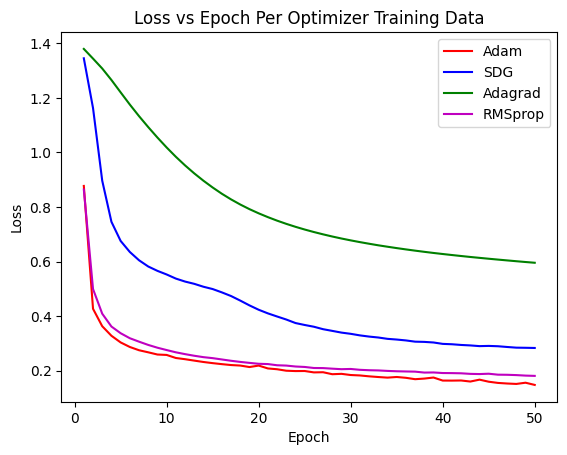

In [96]:
# Plot losses for each optimizer training data

epochs = range(1, len(nn_model_adam_losses) + 1)

plt.plot(epochs, nn_model_adam_losses, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_losses, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_losses, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_losses, 'm', label = 'RMSprop')

plt.title('Loss vs Epoch Per Optimizer Training Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

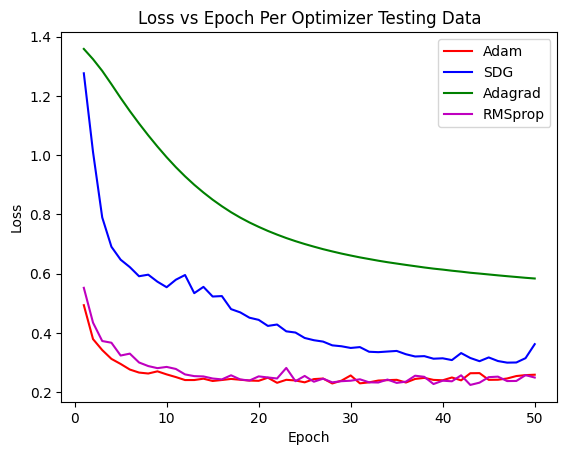

In [97]:
# Plot losses for each optimizer testing data

epochs = range(1, len(nn_model_adam_losses) + 1)

plt.plot(epochs, nn_model_adam_val_losses, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_val_losses, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_val_losses, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_val_losses, 'm', label = 'RMSprop')

plt.title('Loss vs Epoch Per Optimizer Testing Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

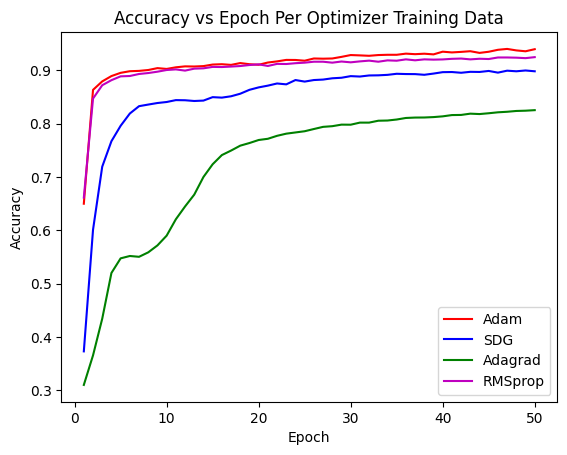

In [98]:
# Plot accuracy for each optimizer

epochs = range(1, len(nn_model_adam_accuracy) + 1)

plt.plot(epochs, nn_model_adam_accuracy, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_accuracy, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_accuracy, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_accuracy, 'm', label = 'RMSprop')

plt.title('Accuracy vs Epoch Per Optimizer Training Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

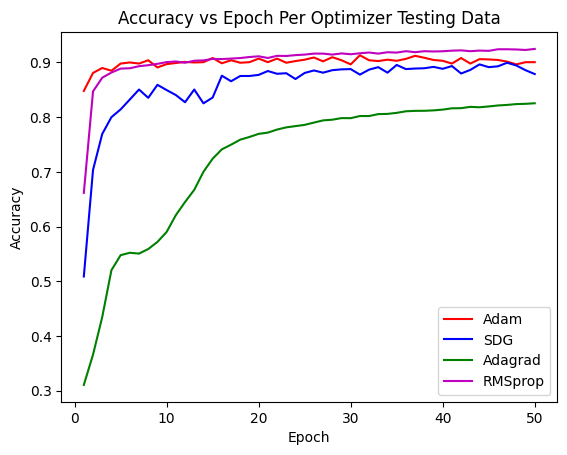

In [101]:
# Plot accuracy for each optimizer testing data

epochs = range(1, len(nn_model_adam_losses) + 1)

plt.plot(epochs, nn_model_adam_val_accuracy, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_val_accuracy, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_accuracy, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_accuracy, 'm', label = 'RMSprop')

plt.title('Accuracy vs Epoch Per Optimizer Testing Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [102]:
# Model Activation Relu
units = units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_relu = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_relu.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
nn_model_relu_losses = []
model_loss, model_accuracy = nn_model_relu.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation ReLU Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5071 - loss: 1.0823 - val_accuracy: 0.8480 - val_loss: 0.5545
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8459 - loss: 0.5404 - val_accuracy: 0.8737 - val_loss: 0.4341
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8706 - loss: 0.4299 - val_accuracy: 0.8823 - val_loss: 0.3806
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8867 - loss: 0.3611 - val_accuracy: 0.8833 - val_loss: 0.3428
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8855 - loss: 0.3345 - val_accuracy: 0.8823 - val_loss: 0.3261
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8945 - loss: 0.3017 - val_accuracy: 0.8980 - val_loss: 0.2929
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8973 - loss: 0.2897 - val_accuracy: 0.8960 - val_loss: 0.2778
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8991 - loss: 0.2764 - val_accuracy: 0.

In [103]:
# Make predictions using testing data
predictions = nn_model_relu.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation ReLU')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation ReLU")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation ReLU
[[729  65  22  26]
 [ 27 767  28  24]
 [  5  26 769  20]
 [ 27  32  13 720]]
Classification Report Model Activation ReLU
              precision    recall  f1-score   support

      Cloudy       0.93      0.87      0.89       842
       Rainy       0.86      0.91      0.88       846
       Snowy       0.92      0.94      0.93       820
       Sunny       0.91      0.91      0.91       792

    accuracy                           0.90      3300
   macro avg       0.91      0.90      0.90      3300
weighted avg       0.91      0.90      0.90      3300



In [104]:
nn_model_relu_losses = fit_model.history['loss']
nn_model_relu_accuracy = fit_model.history['accuracy']
nn_model_relu_val_losses = fit_model.history['val_loss']
nn_model_relu_val_accuracy = fit_model.history['val_accuracy']

In [105]:
# Model Activation LeakyReLU
units = [64, 32, 16, 8]
activations_funcs = [LeakyReLU(alpha=0.01), LeakyReLU(alpha=0.01), LeakyReLU(alpha=0.01), LeakyReLU(alpha=0.01)]
nn_model_leakyrelu = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_leakyrelu.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
nn_model_leakyrelu_losses = []
model_loss, model_accuracy = nn_model_leakyrelu.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation LeakyReLU Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5378 - loss: 1.0691 - val_accuracy: 0.8449 - val_loss: 0.5279
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8625 - loss: 0.4832 - val_accuracy: 0.8833 - val_loss: 0.4304
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8788 - loss: 0.4270 - val_accuracy: 0.8687 - val_loss: 0.4024
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8904 - loss: 0.3624 - val_accuracy: 0.8798 - val_loss: 0.3507
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8939 - loss: 0.3312 - val_accuracy: 0.8899 - val_loss: 0.3205
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8891 - loss: 0.3189 - val_accuracy: 0.8924 - val_loss: 0.3064
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8966 - loss: 0.2925 - val_accuracy: 0.8788 - val_loss: 0.3242
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8913 - loss: 0.3000 - val_accuracy: 0.8970 - val_

In [106]:
# Make predictions using testing data
predictions = nn_model_leakyrelu.predict(X_test)

# Convert one-hot encoded values to categorical labels
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation LeakyReLU')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation LeakyReLU")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation LeakyReLU
[[751  26  38  27]
 [ 46 738  38  24]
 [ 11   6 781  22]
 [ 24   9  31 728]]
Classification Report Model Activation LeakyReLU
              precision    recall  f1-score   support

      Cloudy       0.90      0.89      0.90       842
       Rainy       0.95      0.87      0.91       846
       Snowy       0.88      0.95      0.91       820
       Sunny       0.91      0.92      0.91       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [107]:
nn_model_leakyrelu_losses = fit_model.history['loss']
nn_model_leakyrelu_accuracy = fit_model.history['accuracy']
nn_model_leakyrelu_val_losses = fit_model.history['val_loss']
nn_model_leakyrelu_val_accuracy = fit_model.history['val_accuracy']

In [108]:
# Model Activation PReLU
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_prelu = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_prelu.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
nn_model_prelu_losses = []
model_loss, model_accuracy = nn_model_prelu.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation PReLU Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5694 - loss: 1.0579 - val_accuracy: 0.8540 - val_loss: 0.5077
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8525 - loss: 0.4876 - val_accuracy: 0.8732 - val_loss: 0.4151
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8757 - loss: 0.4004 - val_accuracy: 0.8874 - val_loss: 0.3717
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8798 - loss: 0.3674 - val_accuracy: 0.8904 - val_loss: 0.3356
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8868 - loss: 0.3407 - val_accuracy: 0.8924 - val_loss: 0.3138
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8981 - loss: 0.3065 - val_accuracy: 0.8960 - val_loss: 0.3057
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8921 - loss: 0.2944 - val_accuracy: 0.8848 - val_loss: 0.3014
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8935 - loss: 0.2981 - val_accuracy: 0.

In [109]:
# Make predictions using testing data
predictions = nn_model_prelu.predict(X_test)

# Convert one-hot encoded values to categorical labels
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation PReLU')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation PReLU")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation PReLU
[[764  26  25  27]
 [ 64 733  33  16]
 [ 21  14 768  17]
 [ 38  15  17 722]]
Classification Report Model Activation PReLU
              precision    recall  f1-score   support

      Cloudy       0.86      0.91      0.88       842
       Rainy       0.93      0.87      0.90       846
       Snowy       0.91      0.94      0.92       820
       Sunny       0.92      0.91      0.92       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [110]:
nn_model_prelu_losses = fit_model.history['loss']
nn_model_prelu_accuracy = fit_model.history['accuracy']
nn_model_prelu_val_losses = fit_model.history['val_loss']
nn_model_prelu_val_accuracy = fit_model.history['val_accuracy']

In [111]:
# Model Activation Swish
def swish(x):
    return x * tf.sigmoid(x)

units = [64, 32, 16, 8]
activations_funcs = [swish, swish, swish, swish]
nn_model_swish = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_swish.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
nn_model_swish_losses = []
model_loss, model_accuracy = nn_model_swish.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation Swish Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5550 - loss: 1.0841 - val_accuracy: 0.8379 - val_loss: 0.5105
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8509 - loss: 0.4869 - val_accuracy: 0.8869 - val_loss: 0.4045
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8764 - loss: 0.4013 - val_accuracy: 0.8828 - val_loss: 0.3644
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8830 - loss: 0.3551 - val_accuracy: 0.8944 - val_loss: 0.3240
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8896 - loss: 0.3204 - val_accuracy: 0.8717 - val_loss: 0.3352
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8949 - loss: 0.3034 - val_accuracy: 0.9000 - val_loss: 0.2792
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8949 - loss: 0.2952 - val_accuracy: 0.8919 - val_loss: 0.2787
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8978 - loss: 0.2777 - val_accuracy: 0.

In [112]:
# Make predictions using testing data
predictions = nn_model_swish.predict(X_test)

# Convert one-hot encoded values to categorical labels
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation Swish')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation Swish")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation Swish
[[752  38  32  20]
 [ 56 733  43  14]
 [ 17  12 779  12]
 [ 34  18  20 720]]
Classification Report Model Activation Swish
              precision    recall  f1-score   support

      Cloudy       0.88      0.89      0.88       842
       Rainy       0.92      0.87      0.89       846
       Snowy       0.89      0.95      0.92       820
       Sunny       0.94      0.91      0.92       792

    accuracy                           0.90      3300
   macro avg       0.91      0.90      0.90      3300
weighted avg       0.91      0.90      0.90      3300



In [113]:
nn_model_swish_losses = fit_model.history['loss']
nn_model_swish_accuracy = fit_model.history['accuracy']
nn_model_swish_val_losses = fit_model.history['val_loss']
nn_model_swish_val_accuracy = fit_model.history['val_accuracy']

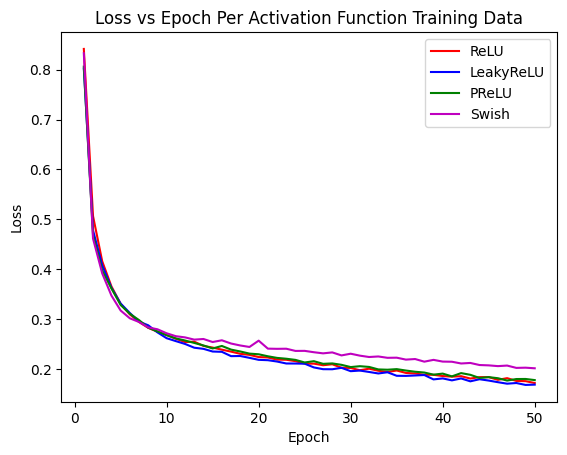

In [119]:
# Plot losses for each activation function training data

epochs = range(1, len(nn_model_relu_losses) + 1)

plt.plot(epochs, nn_model_relu_losses, 'r', label = 'ReLU')
plt.plot(epochs, nn_model_leakyrelu_losses, 'b', label = 'LeakyReLU')
plt.plot(epochs, nn_model_prelu_losses, 'g', label = 'PReLU')
plt.plot(epochs, nn_model_swish_losses, 'm', label = 'Swish')

plt.title('Loss vs Epoch Per Activation Function Training Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

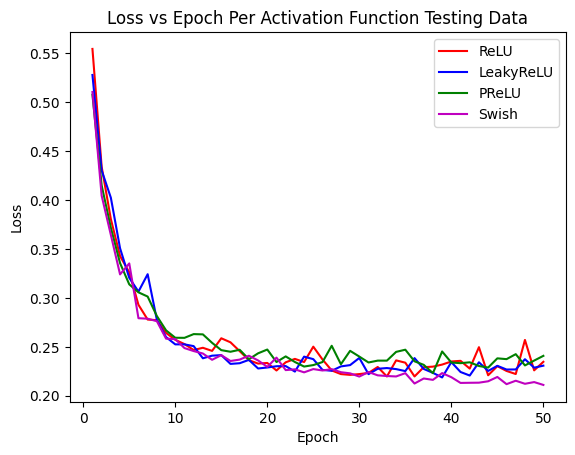

In [118]:
# Plot losses for each activation function testing data

epochs = range(1, len(nn_model_relu_losses) + 1)

plt.plot(epochs, nn_model_relu_val_losses, 'r', label = 'ReLU')
plt.plot(epochs, nn_model_leakyrelu_val_losses, 'b', label = 'LeakyReLU')
plt.plot(epochs, nn_model_prelu_val_losses, 'g', label = 'PReLU')
plt.plot(epochs, nn_model_swish_val_losses, 'm', label = 'Swish')

plt.title('Loss vs Epoch Per Activation Function Testing Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

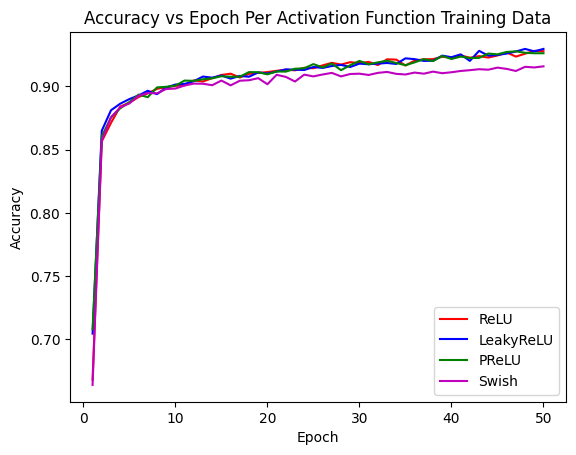

In [116]:
# Plot accuracy for each activation function testing data

epochs = range(1, len(nn_model_relu_accuracy) + 1)

plt.plot(epochs, nn_model_relu_accuracy, 'r', label = 'ReLU')
plt.plot(epochs, nn_model_leakyrelu_accuracy, 'b', label = 'LeakyReLU')
plt.plot(epochs, nn_model_prelu_accuracy, 'g', label = 'PReLU')
plt.plot(epochs, nn_model_swish_accuracy, 'm', label = 'Swish')

plt.title('Accuracy vs Epoch Per Activation Function Training Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

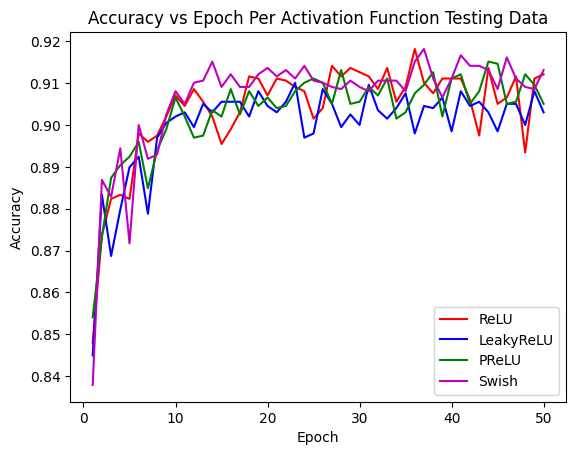

In [117]:
# Plot accuracy for each activation function testing data

epochs = range(1, len(nn_model_relu_accuracy) + 1)

plt.plot(epochs, nn_model_relu_val_accuracy, 'r', label = 'ReLU')
plt.plot(epochs, nn_model_leakyrelu_val_accuracy, 'b', label = 'LeakyReLU')
plt.plot(epochs, nn_model_prelu_val_accuracy, 'g', label = 'PReLU')
plt.plot(epochs, nn_model_swish_val_accuracy, 'm', label = 'Swish')

plt.title('Accuracy vs Epoch Per Activation Function Testing Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()